# Visualisation des données

Nous souhaitons faire un programme d’affichage et de visualisation des données, qui servira de proof-of-concept pour les fiches descriptives des éditions/sports/athlètes/disciplines. 
Pour ce faire, nous allons utiliser Python et 2 bibliothèques spécifiques :
* neo4j pour l’interaction avec le graphe : envoi de requêtes et récupération de résultats
* une bibliothèque de visualisation (comme par exemple matplotlib, pyplot ou seaborn) 

Les possibilités étant très larges, nous allons choisir d'afficher des graphiques/infos pour au choix :
* un athlète 
* une discipline 
* un sport 
* une édition des jeux olympiques 

Nous allons choisir les requêtes/visualisations qui mettront le mieux nos données en valeur. Au moins 5 visualisations sont attendues pour l’athlète/sport/discipline/édition choisi.

Idéalement, le programme sera paramétrable et permettra à l’utilisateur d’entrer un nom d’athlète/discipline/sport/année d’édition avant d’avoir les visualisations.

In [4]:
pip install neo4j

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\camil\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import logging

from neo4j import GraphDatabase, RoutingControl
from neo4j.exceptions import DriverError, Neo4jError

# pour les graphiques
import matplotlib.pyplot as plt

import pandas as pd

Connexion à la base de données :

*issu du site [neo4j](https://neo4j.com/docs/python-manual/current/)*

In [ ]:
# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j://127.0.0.1:7687"
AUTH = ("neo4j", "<password>")

GraphDatabase.driver(URI, auth=AUTH)

Les codes utilisés par la suite sont adaptés des exemples officiels Neo4j.

Voir https://neo4j.com/docs/api/python-driver/current/

## Athlete

Nous allons afficher pour un athlete donné :
* le nombre de tweets par année
* le nombre de médaille obtenue chaque année où il a participé
* le pourcentage de médaille obtenu parmis celles gagnées par le pays l'année de sa participation
* les disciplines dans lesquelles il participe
* le pourcentage de représentation de son sexe dans les éditions où il a participé

Ci-dessous le code global :

The query `MATCH (a:athlete {name:'Raman Piatrushenka'})<-[:MENTIONS_ATHLETE]-(t:tweet) RETURN count(t) AS tweet_count, substring(t.date, 0, 4) AS annee` returned 0 records in 34 ms.


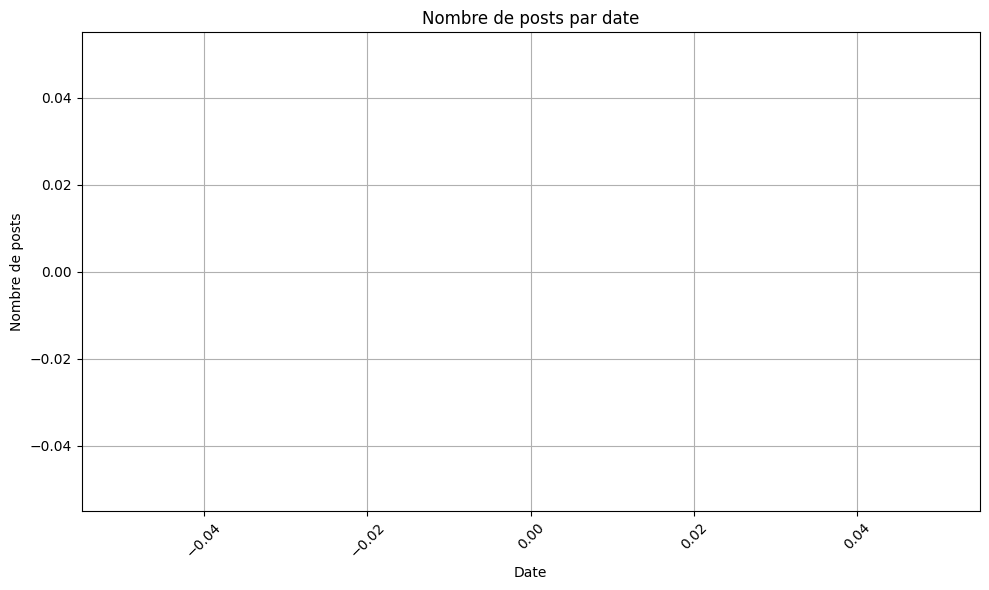

WARNING ! Risque de doublons pour cause d'homonymes.
The query `MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name:'Raman Piatrushenka'})-[h:HAS_RESULT]->(r:result)-[:AWARDS]->(m:medal), (g)<-[:PARTICIPATES_IN]-(c:country)-[o:OWNS_RESULT]->(res:result), (a)-[:REPRESENTS]->(c) WHERE g.edition_id=o.edition_country AND o.edition_country=h.edition_athlete RETURN g.year AS annee, COUNT(DISTINCT m) AS nombre_de_medailles_athlete, res.total AS total_medailles_pays ORDER BY annee; ` returned 3 records in 25 ms.
WARNING ! Risque de doublons pour cause d'homonymes.
The query `MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name: 'Raman Piatrushenka'}), (g)<-[:PARTICIPATES_IN]-(c:country)-[o:OWNS_RESULT]->(res:result), (a)-[:REPRESENTS]->(c) WHERE g.edition_id=o.edition_country RETURN g.year AS annee, res.total AS total_medailles_pays ORDER BY annee; ` returned 3 records in 15 ms.


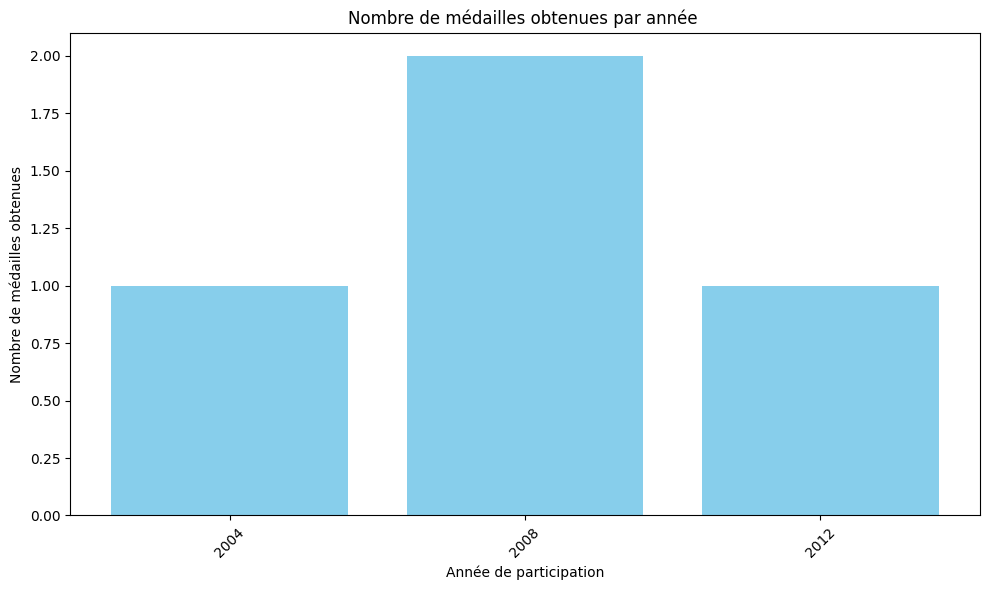

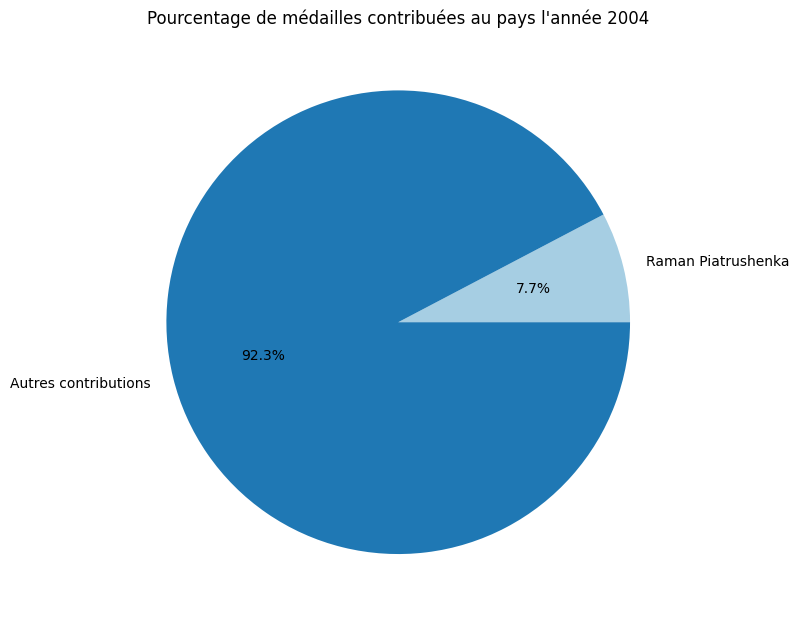

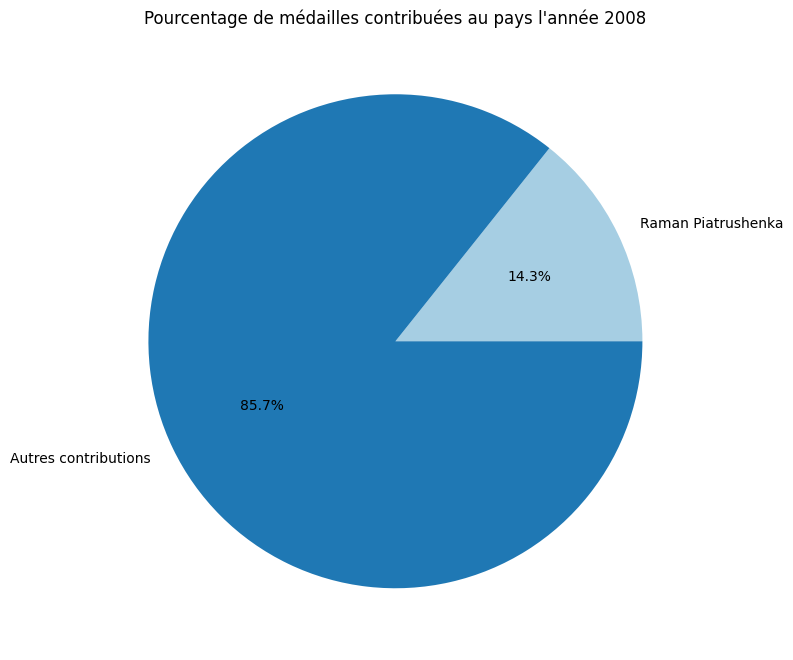

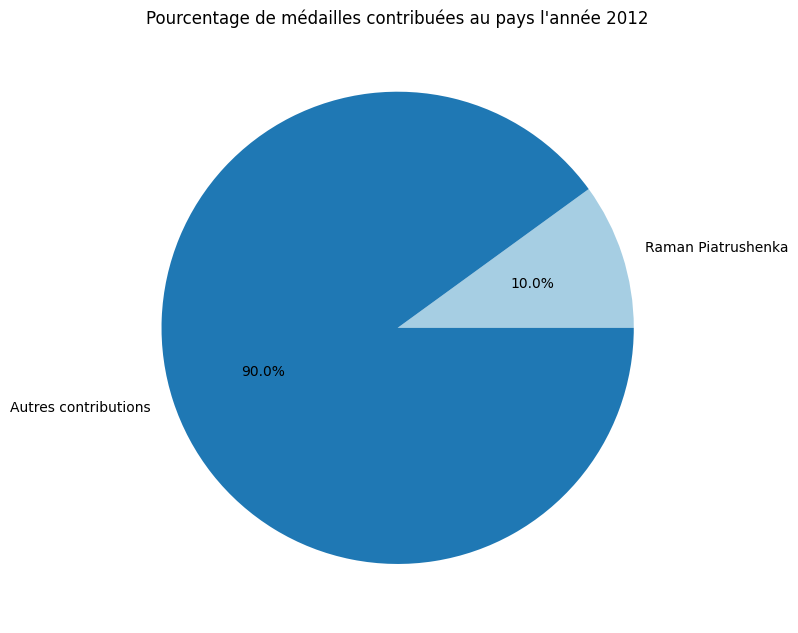

WARNING ! Risque de doublons pour cause d'homonymes.
The query `MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name:'Raman Piatrushenka'})-[]->(d:discipline) RETURN d.discipline AS discipline, COUNT(DISTINCT g) AS nb_participations ORDER BY discipline; ` returned 2 records in 22 ms.


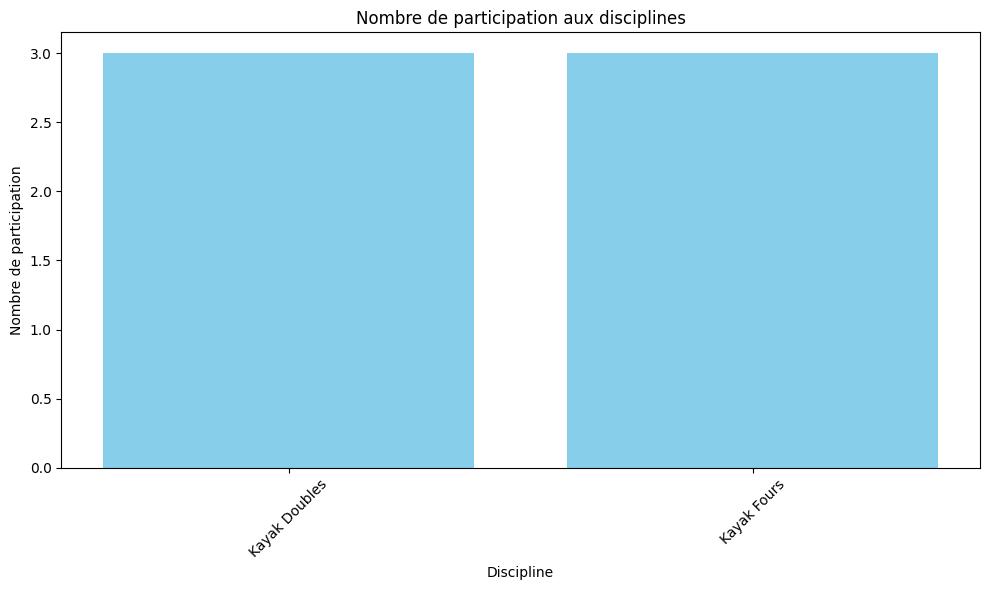

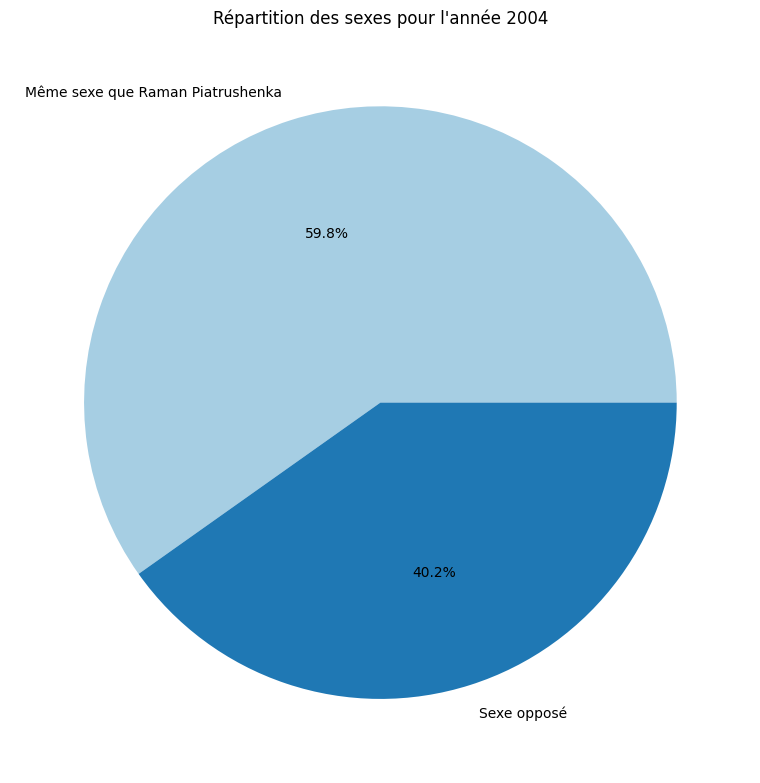

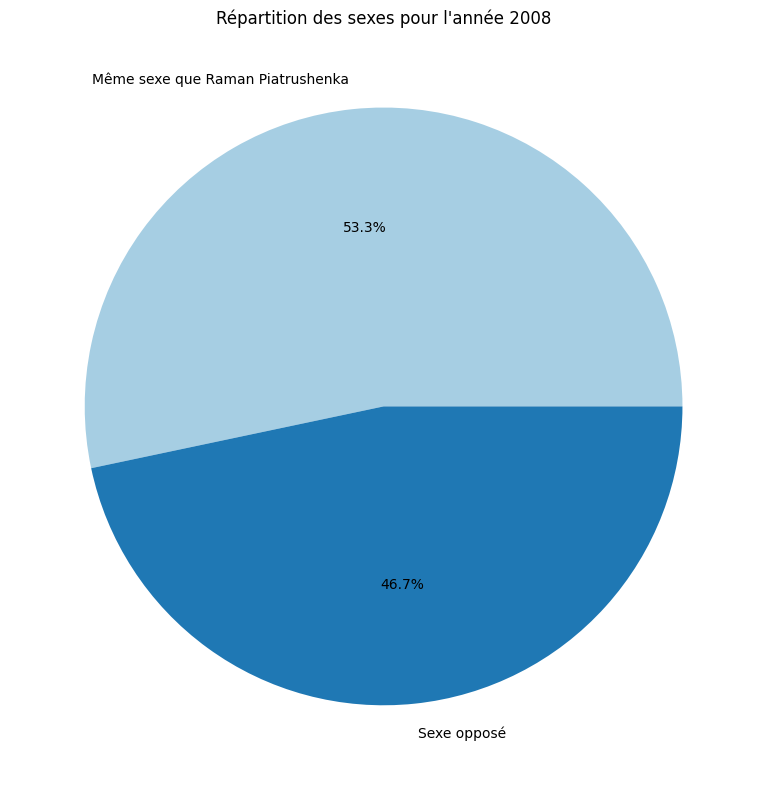

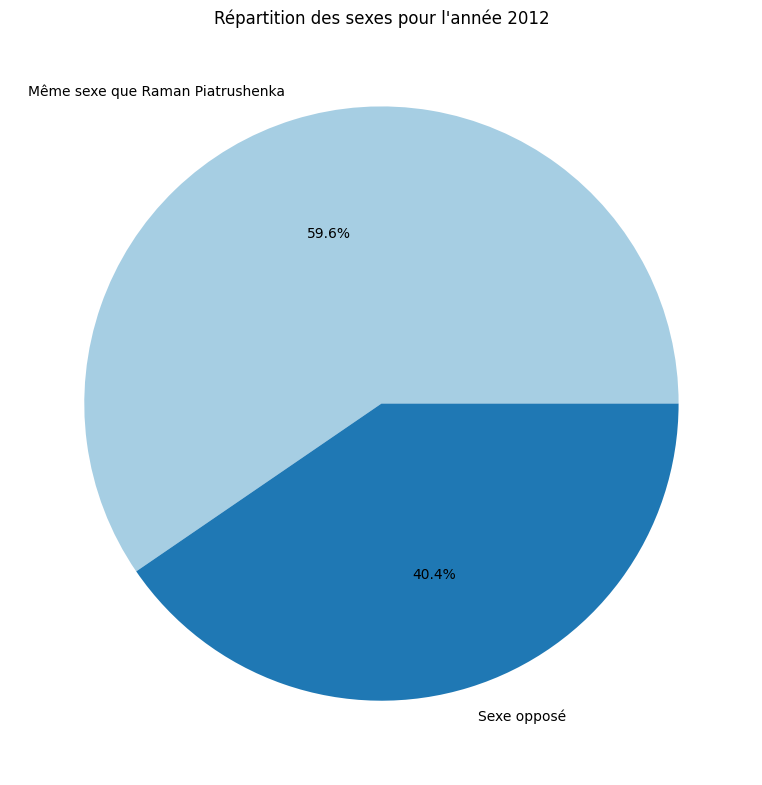

In [ ]:
class App:

#--------------------------#
# Constructeur
#--------------------------#
    def __init__(self, uri, user, password, database=None):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.database = database

#--------------------------#
# Méthodes
#--------------------------#
    def close(self):
        # Ne pas oublier de fermer le driver
        self.driver.close()


    def nb_post(self, athlete_name:str)->None:
        """
        La fonction permet de connaître le nombre de tweets par année qui mentionne l'athlète.

        Args:
            athlete_name (str): correspond au nom complet de l'athlète au format "Prénom Nom".
        """
        # Lancement de la requête cypher    
        query = (
            "MATCH (a:athlete {name:'"+athlete_name+"'})<-[:MENTIONS_ATHLETE]-(t:tweet) "
            "RETURN count(t) AS tweet_count, substring(t.date, 0, 4) AS annee"
        )
        records, summary, keys = self.driver.execute_query(
            query,
            database_=self.database, routing_=RoutingControl.READ
        )
        
        # Affichage des statistiques
        print("The query `{query}` returned {records_count} records in {time} ms.".format(
        query=summary.query, records_count=len(records),
        time=summary.result_available_after
        ))
        
        # Récupération de la requête et traitement
        tweet, date = [], []
        for record in records:
            tweet.append(record["tweet_count"])
            date.append(record["annee"])
        
        # Création d'un graphique en courbe (line chart)
        plt.figure(figsize=(10, 6))
        plt.plot(date, tweet, marker='o', linestyle='-', color='b')
        plt.xlabel('Date')
        plt.ylabel('Nombre de posts')
        plt.title('Nombre de posts par date')
        plt.xticks(rotation=45)
        #plt.axes().set_xticklabels(plt.axes().get_xticks().astype(int))
        plt.grid()
        plt.tight_layout()
        plt.show()
        
    def query_medal(self, athlete_name:str, athlete_born:str = None, athlete_pays:str = None )->int:
        """
        Fonction permettant la récupération des informations concernant les médailles de l'athlète et de son pays (total).

        Args:
            athlete_name (str): nom de l'athlète
            athlete_born (str, optional): date de naissance de l'athlète. Defaults to None.
            athlete_pays (str, optional): pays de naissance de l'athlète (celui qu'il représente). Defaults to None.

        Returns:
            int: les années auxquelles il a participé, le nombre de médailles qu'il a alors obtenu, le nombre total de médailles qu'a obtenu son pays.
        """
        if athlete_born is not None :
            # Lancement de la requête cypher    
            query = (
                "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name:'"+athlete_name+"', born: '"+athlete_born+"'})-[h:HAS_RESULT]->(r:result)-[:AWARDS]->(m:medal), "
                "(g)<-[:PARTICIPATES_IN]-(c:country)-[o:OWNS_RESULT]->(res:result), (a)-[:REPRESENTS]->(c) "
                "WHERE g.edition_id=o.edition_country AND o.edition_country=h.edition_athlete "
                "RETURN g.year AS annee, COUNT(DISTINCT m) AS nombre_de_medailles_athlete, res.total AS total_medailles_pays "
                "ORDER BY annee; "
            )
        elif athlete_pays is not None:
            # Lancement de la requête cypher    
            query = (
                "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name: '"+athlete_name+"'})-[h:HAS_RESULT]->(r:result)-[:AWARDS]->(m:medal), "
                "(g)<-[:PARTICIPATES_IN]-(c:country {country: '"+athlete_pays+"'})-[o:OWNS_RESULT]->(res:result), (a)-[:REPRESENTS]->(c) "
                "WHERE g.edition_id=o.edition_country AND o.edition_country=h.edition_athlete "
                "RETURN g.year AS annee, COUNT(DISTINCT m) AS nombre_de_medailles_athlete, res.total AS total_medailles_pays "
                "ORDER BY annee;"
            )
        else:
            print("WARNING ! Risque de doublons pour cause d'homonymes.")
            # Lancement de la requête cypher    
            query = (
                "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name:'"+athlete_name+"'})-[h:HAS_RESULT]->(r:result)-[:AWARDS]->(m:medal), "
                "(g)<-[:PARTICIPATES_IN]-(c:country)-[o:OWNS_RESULT]->(res:result), (a)-[:REPRESENTS]->(c) "
                "WHERE g.edition_id=o.edition_country AND o.edition_country=h.edition_athlete "
                "RETURN g.year AS annee, COUNT(DISTINCT m) AS nombre_de_medailles_athlete, res.total AS total_medailles_pays "
                "ORDER BY annee; "
            )
        
        records, summary, keys = self.driver.execute_query(
            query,
            database_=self.database, routing_=RoutingControl.READ
        )
        
        # Affichage des statistiques
        print("The query `{query}` returned {records_count} records in {time} ms.".format(
        query=summary.query, records_count=len(records),
        time=summary.result_available_after
        ))
        
        # Récupération de la requête et traitement
        annee, medal_A, medal_C = [], [], []
        for record in records:
            annee.append(record["annee"])
            medal_A.append(record["nombre_de_medailles_athlete"])
            medal_C.append(record["total_medailles_pays"])
        
        return annee, medal_A, medal_C
    
    def graphique_medal(self, athlete_name:str, athlete_born:str = None, athlete_pays:str = None, percent_medal:bool = True, nb_medal:bool = True )->None:
        """
        Fonction permettant d'afficher divers graphiques sur les médailles d'un athlète.

        Args:
            athlete_name (str): nom de l'athlète
            athlete_born (str, optional): date de naissance de l'athlète. Defaults to None.
            athlete_pays (str, optional): pays de naissance de l'athlète. Defaults to None.
            percent_medal (bool, optional): indique si l'on veut visualiser le graphique sur les pourcentages de médailles (pie plot). Defaults to True.
            nb_medal (bool, optional): indique si l'on veut visualiser le graphique sur le nombre de médailles (bar plot). Defaults to True.
        """
            
        # Récupération du nombre de médailles obtenues
        query = self.query_medal(athlete_name=athlete_name, athlete_born=athlete_born, athlete_pays=athlete_pays)
        annee_A, nb_A = query[0], query[1]

        # Vérification du nombre de participations
        if athlete_born is not None :
            # Lancement de la requête cypher    
            query = (
                "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name:'"+athlete_name+"', born: '"+athlete_born+"'}), "
                "(g)<-[:PARTICIPATES_IN]-(c:country)-[o:OWNS_RESULT]->(res:result), (a)-[:REPRESENTS]->(c) "
                "WHERE g.edition_id=o.edition_country "
                "RETURN g.year AS annee, res.total AS total_medailles_pays ORDER BY annee; "
            )
        
        elif athlete_pays is not None:
            # Lancement de la requête cypher    
            query = (
                "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name:'"+athlete_name+"'}), "
                "(g)<-[:PARTICIPATES_IN]-(c:country {country: '"+athlete_pays+"'})-[o:OWNS_RESULT]->(res:result), (a)-[:REPRESENTS]->(c) "
                "WHERE g.edition_id=o.edition_country "
                "RETURN g.year AS annee, res.total AS total_medailles_pays ORDER BY annee; "
            )
        
        else:
            print("WARNING ! Risque de doublons pour cause d'homonymes.")
            # Lancement de la requête cypher    
            query = (
                "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name: '"+athlete_name+"'}), "
                "(g)<-[:PARTICIPATES_IN]-(c:country)-[o:OWNS_RESULT]->(res:result), (a)-[:REPRESENTS]->(c) "
                "WHERE g.edition_id=o.edition_country "
                "RETURN g.year AS annee, res.total AS total_medailles_pays ORDER BY annee; "
            )
        
        records, summary, keys = self.driver.execute_query(
            query,
            database_=self.database, routing_=RoutingControl.READ
        )
        
        # Affichage des statistiques
        print("The query `{query}` returned {records_count} records in {time} ms.".format(
        query=summary.query, records_count=len(records),
        time=summary.result_available_after
        ))
        
        # Récupération de la requête et traitement
        annee, nb_C = [], []
        for record in records:
            annee.append(record["annee"])
            nb_C.append(record["total_medailles_pays"])
        
        gain = pd.DataFrame({"annee":annee_A, "gain":nb_A})
        all = pd.DataFrame({"annee":annee, "total":nb_C})
        data = pd.merge(gain, all, how="outer", on="annee")
        data = data.fillna(0)
        an = data["annee"]
        an = an.tolist()
        medal=data["gain"]
        medal=medal.tolist()
        total=data["total"]
        total=total.tolist()

        if nb_medal:
            # Création d'un graphique histogramme (bar chart)
            plt.figure(figsize=(10, 6))
            plt.bar([str(a) for a in an], [int(float(m)) for m in medal], color='skyblue')
            plt.xlabel('Année de participation')
            plt.ylabel('Nombre de médailles obtenues')
            plt.title('Nombre de médailles obtenues par année ')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        if percent_medal:
            index=-1
            # Création d'un graphique camembert (pie chart)
            for element in an:
                index+=1
                total_year = data.iloc[index, 2]
                total_year = int(float(total_year))
                if total_year==0:
                    total_year+=1
                medal_year = data.iloc[index, 1]
                medal_year = int(medal_year.tolist())
                x_value = [medal_year, total_year-medal_year]
                labels = [f"{athlete_name}","Autres contributions"]
                plt.figure(figsize=(8, 8))
                plt.pie(x_value, labels=labels, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
                plt.title(f"Pourcentage de médailles contribuées au pays l'année {element}")
                plt.tight_layout()
                plt.show()
    
    def nb_medal(self, athlete_name:str, athlete_born:str = None, athlete_pays:str = None)->None:
        """
        Fonction permettant d'afficher le nombre de médailles obtenues par l'athlète sur les années où il a participé.

        Args:
            athlete_name (str): nom de l'athlète
            athlete_born (str, optional): date de naissance de l'athlète. Defaults to None.
            athlete_pays (str, optional): pays de naissance de l'athlète. Defaults to None.
        """
        percent_medal, nb_medal = False, True
        App.graphique_medal(athlete_name, athlete_born, athlete_pays, percent_medal, nb_medal)
    
    def percent_medal(self, athlete_name:str, athlete_born:str = None, athlete_pays:str = None)->None:
        """
        Fonction permettant d'afficher le pourcentage de médailles obtenues par l'athlète sur les années où il a participé qui ont contribuées au score total du pays.

        Args:
            athlete_name (str): nom de l'athlète
            athlete_born (str, optional): date de naissance de l'athlète. Defaults to None.
            athlete_pays (str, optional): pays de naissance de l'athlète. Defaults to None.
        """
        percent_medal, nb_medal = True, False
        App.graphique_medal(athlete_name, athlete_born, athlete_pays, percent_medal, nb_medal)
    
    def discipline(self, athlete_name:str, athlete_born:str = None, athlete_pays:str = None)->None:
        """
        Fonction permettant d'afficher un histogramme des participations de l'athlète selon les disciplines.

        Args:
            athlete_name (str): nom de l'athlète
            athlete_born (str, optional): date de naissance de l'athlète. Defaults to None.
        """
        if athlete_born is not None :
            # Lancement de la requête cypher
            query = (
                "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name: '"+athlete_name+"', born: '"+athlete_born+"'})-[]->(d:discipline) "
                "RETURN d.discipline AS discipline, COUNT(DISTINCT g) AS nb_participations "
                "ORDER BY discipline; "
            )
        elif athlete_pays is not None :
            # Lancement de la requête cypher
            query = (
                "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name: '"+athlete_name+"', country: '"+athlete_country+"'})-[]->(d:discipline) "
                "RETURN d.discipline AS discipline, COUNT(DISTINCT g) AS nb_participations "
                "ORDER BY discipline; "
            )
        else:
            print("WARNING ! Risque de doublons pour cause d'homonymes.")
            # Lancement de la requête cypher    
            query = (
            "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name:'"+athlete_name+"'})-[]->(d:discipline) "
            "RETURN d.discipline AS discipline, COUNT(DISTINCT g) AS nb_participations "
            "ORDER BY discipline; "
            )
        records, summary, keys = self.driver.execute_query(
            query,
            database_=self.database, routing_=RoutingControl.READ
        )
        
        # Affichage des statistiques
        print("The query `{query}` returned {records_count} records in {time} ms.".format(
        query=summary.query, records_count=len(records),
        time=summary.result_available_after
        ))
        
        # Récupération de la requête et traitement
        discipline, nb_participation = [], []
        for record in records:
            discipline.append(record["discipline"])
            nb_participation.append(record["nb_participations"])

        # Création d'un graphique histogramme (bar chart)
        plt.figure(figsize=(10, 6))
        plt.bar(discipline, nb_participation, color='skyblue')
        plt.xlabel('Discipline')
        plt.ylabel('Nombre de participation')
        plt.title('Nombre de participation aux disciplines')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def sex_percent(self, athlete_name:str)->None:
        """
        Fonction permettant l'affichage d'un graphique (pie plot) regroupant le pourcentage de représentation du sexe de l'athlète dans l'édition à laquelle il a participé.

        Args:
            athlete_name (str): nom de l'athlète
        """
        # Lancement de la requête cypher
        query = (
            "MATCH (g:GamesEdition)<-[:PLAYS_IN]-(a:athlete {name: '"+athlete_name+"'}) "
            "RETURN a.sex AS sexe"
        )
        records, summary, keys = self.driver.execute_query(
            query,
            database_=self.database, routing_=RoutingControl.READ
        )
        sexe = []
        for record in records:
            sexe.append(record["sexe"])
        sexe = str(sexe[0])
        
        query = (
            "MATCH (g:GamesEdition)<-[]-(a:athlete {name: '"+athlete_name+"'}), (g)<-[]-(autre:athlete {sex: '"+sexe+"'}) "
            "RETURN g.year AS annee, count(autre) AS nb_same_sex"                
        )
        records, summary, keys = self.driver.execute_query(
            query,
            database_=self.database, routing_=RoutingControl.READ
        )
        nb_same_sex, annee = [], []
        for record in records:
            annee.append(record["annee"])
            nb_same_sex.append(record["nb_same_sex"])
        
        query = (
            "MATCH (g:GamesEdition)<-[]-(a:athlete {name: '"+athlete_name+"'}), (g)<-[]-(autre:athlete) "
            "RETURN g.year AS annee, count(autre) AS all"                
        )
        records, summary, keys = self.driver.execute_query(
            query,
            database_=self.database, routing_=RoutingControl.READ
        )
        all, annee = [], []
        for record in records:
            annee.append(record["annee"])
            all.append(record["all"])
        
        # Récupération de la requête et traitement
        same = pd.DataFrame({"annee":annee, "nb_same_sex":nb_same_sex})
        tous = pd.DataFrame({"annee":annee, "all":all})

        data = pd.merge(same, tous, how="outer", on="annee")
        data = data.fillna(0)

        index=-1
        # Création d'un graphique camembert (pie chart)
        for element in annee:
            index+=1
            total = data.iloc[index, 2]
            total = int(total.tolist())
            sexe_same = data.iloc[index, 1]
            sexe_same = int(sexe_same.tolist())
            x_value = [sexe_same, total-sexe_same]
            labels = [f"Même sexe que {athlete_name}","Sexe opposé"]
            plt.figure(figsize=(8, 8))
            plt.pie(x_value, labels=labels, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
            plt.title(f"Répartition des sexes pour l'année {element}")
            plt.tight_layout()
            plt.show()
    
    
#--------------------------#
# Main
#--------------------------#
if __name__ == "__main__":

    scheme = "neo4j"  
    host_name = "localhost"
    port = 7687
    uri = f"{scheme}://{host_name}:{port}"
    user = "neo4j"
    password = "<password>"
    database = "jeuxolympiques"
    app = App(uri, user, password, database)
    
    pays, date_naissance = None, None
    
    nom = input("Entrez le nom de l'athlète : ")
    test = input("Avez-vous le pays de l'athlète ? (o:oui, n:non)")
    if test=="o":
        pays = input("Entrez le pays de l'athlète : ")
    test = input("Avez-vous la date de naissance de l'athlète ? (o:oui, n:non)")
    if test=="o":
        date_naissance = input("Entrez la date de naissance de l'athlète : ")
    
    try:
        app.nb_post(nom)
        app.graphique_medal(athlete_name=nom, athlete_born=date_naissance, athlete_pays=pays)
        app.discipline(nom, date_naissance)
        app.sex_percent(nom)

    finally:
        app.close()

Ci-dessous une adaptation du code pour vérification simple de son fonctionnement :

In [ ]:
athlete_name = "Harry Kerr"

# Récupération du nombre de médailles obtenues
annee_A, nb_A = ["2020", "2022"], [3,5]

# Récupération de la requête et traitement
annee, nb_C = ["2016", "2018", "2020", "2022"], [2, 0, 4, 15]

import pandas as pd
gain = pd.DataFrame({"annee":annee_A, "gain":nb_A})
all = pd.DataFrame({"annee":annee, "total":nb_C})
data = pd.merge(gain, all, how="outer", on="annee")
data = data.fillna(0)
an = data["annee"]
an = an.tolist()
medal=data["gain"]
medal=medal.tolist()
total=data["total"]
total=total.tolist()

import matplotlib.pyplot as plt

# Création d'un graphique histogramme (bar chart)
plt.figure(figsize=(10, 6))
plt.bar(an, medal, color='skyblue')
plt.xlabel('Année de participation')
plt.ylabel('Nombre de médailles obtenues')
plt.title('Nombre de médailles obtenues par année ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

index=-1
# Création d'un graphique camembert (pie chart)
for element in an:
    index+=1
    total_year = data.iloc[index, 2]
    total_year = int(total_year.tolist())
    if total_year==0:
        total_year+=1
    medal_year = data.iloc[index, 1]
    medal_year = int(medal_year.tolist())
    x_value = [medal_year, total_year-medal_year]
    labels = [f"{athlete_name}","Autres contribution"]
    plt.figure(figsize=(8, 8))
    plt.pie(x_value, labels=labels, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    plt.title(f"Pourcentage de médailles contribuées au pays l'année {element}")
    plt.tight_layout()
    plt.show()

In [ ]:
tweet, date = [2,5,25], [2016,2018,2020]

# Création d'un graphique en courbe (line chart)
plt.figure(figsize=(10, 6))
plt.plot(date, tweet, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Nombre de posts')
plt.title('Nombre de posts par date')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

tweet, date = [25], [2020]

# Création d'un graphique en courbe (line chart)
plt.figure(figsize=(10, 6))
plt.plot(date, tweet, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Nombre de posts')
plt.title('Nombre de posts par date')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [34]:
test=None

if test is None:
    print("none")

none
